ID2CON seminar on LCToolbox — February 16, 2021  
Laurens Jacobs, Jan Swevers — Technical realization: Joris Gillis, Ronny Moreas  
[laurens.jacobs@kuleuven.be](mailto:laurens.jacobs@kuleuven.be)

## **Identification & control of an overhead crane**  

In this example, we try to obtain a linear time-invariant (LTI) controller for the lab-scale 2D overhead crane depicted below. The actuator of the crane is a linear motor with an industrial motor controller with a high-bandwidth velocity control loop. Hence, we can assume the input signal of our system is the input $u$ (in m/s). The position of the cart, $x$ (in m), is measured through a linear encoder, and the angle of the load, $\theta$ (in rad), is measured through a rotational encoder. The absolute load position $y = x + l \sin(\theta)$ (in m). In this example, we assume the hoisting length $l$ is fixed. The data that we start from were obtained with a length of $l$ = 0.51m. 

<center><img src="helpers/crane.jpg" style="margin-right: 3%; width: 15%;"><img src="helpers/crane_scheme.svg" style="margin-left: 3%; width: 12.5%"></center> 

We have gathered data from the real-setup and prepared a few LCToolbox code snippets to identify a parametric model, design a linear feedback controller, and do some simulations with them. Instead of walking you through the entire procedure, we've just selected a few commands with interesting parameters that you can play with and see how it affects the model or the control performance. 

<div style="color: green; border-color: #C2C2C2; border-style: dashed; padding: 0.5%;"><b>How does it work?</b><br/>You can change the code in all grey boxes yourself and execute them in a real MATLAB engine that is coupled to this webpage. After adapting the code, press Shift + Enter and it will be executed. Note that the order of execution matters (e.g. you can overwrite variables, etc.). On the left side of the code boxes, you see the order in which you executed the commands. When it shows [*], MATLAB is executing the block. You can try it with the block below by just printing a string in the MATLAB terminal. Change the string in the block and press Shift + Enter. Verify it outputs the correct string. It may take a while when you execute it for the first time (MATLAB first has to initialize): </div>

In [1]:
disp('Hello, this is MATLAB speaking to you!')

Hello, this is MATLAB speaking to you!


Run the following block before you start. Whenever you would like to start from scratch, you can execute this block again.

In [2]:
clear; 
addpath(genpath('helpers'));
load('experiments.mat');

### **1. Identification**

#### **1.1 Influence of number of experiments and the duration of the experiments**

We performed measurements with 7 different multisines, each time with a length of 10 periods (after the transient has disappeared). The toolbox automatically uses all this data to your advantage: the more periods, the better the measurement noise can be averaged and the more different multisines, the better the nonlinear distortations can be averaged. The measured frequency response is calculated as follows:

<sub>*Note:* The first time you execute the `bode` command, it may take a while before MATLAB returns a result.</sub>

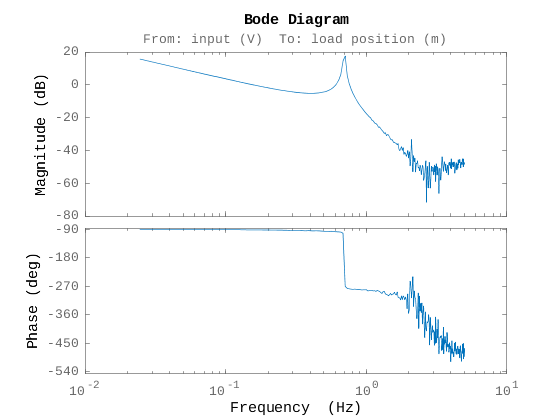

In [3]:
IO = struct('input', 'input (V)', 'output', 'load position (m)');      % define what the method has to consider as input and output signals
Gnp = nonpar_ident(experiment{:}, IO, 'time2frf');                     % calculate the nonparametric transfer function using the 'time2frf' method
bode(Gnp);                                                             % draw a Bode diagram

This frequency response is rather smooth up to 2-3 Hz, far enough beyond the resonance frequency for tight control. At higher frequencies, the amplitudes of the motion becomes so small the encoder quantization distorts the measurements. We will now illustrate the importance of experiments design; that is: making sure the measurements last long enough and there are enough multisine realizations to average nonlinearity. Let us now take the other extreme and use just one experiment and one period:

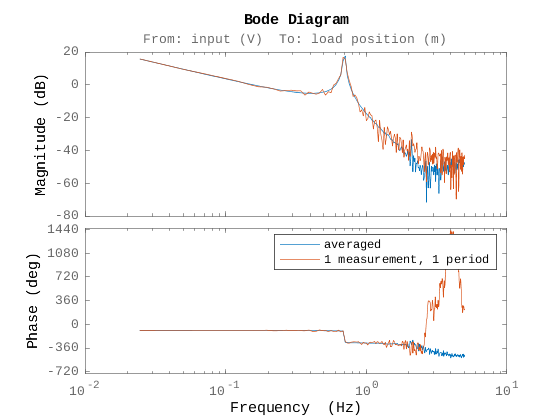

In [4]:
experiment_1period = clip(experiment{1},'firstnper',1);           % clip the first period of experiment 1
Gnp_1period = nonpar_ident(experiment_1period, IO, 'time2frf');   % calculate the new measured frequency response, based on a single period
bode(Gnp,Gnp_1period);                                            % draw a Bode diagram and compare with using all data
legend('averaged','1 measurement, 1 period');                     % add a legend

Try yourself what happens when you increase the number of periods or experiments to be taken into account while calculating the FRF. Here are some example lines to get you started on change the number of periods and the number of experiments:

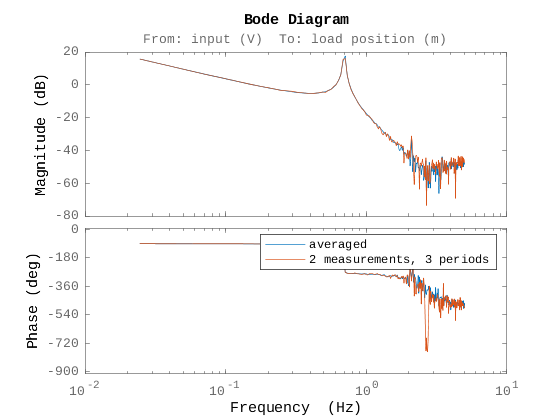

In [5]:
experiment1_3periods = clip(experiment{1},'firstnper',3);                                  % clip the first three periods of experiment 1
experiment4_3periods = clip(experiment{3},'firstnper',3);                                  % clip the first three periods of experiment 4
Gnp_3periods = nonpar_ident(experiment1_3periods, experiment4_3periods, IO, 'time2frf');   % calculate the new measured frequency response, based the three periods of experiment 1 and 4
bode(Gnp,Gnp_3periods);                                                                    % draw a Bode diagram and compare with using all data
legend('averaged','2 measurements, 3 periods');                                            % add a legend

As is (hopefully) clear from this example, there is a trade-off between the desired model accuracy and the time you would like to invest in identification experiments. From only a few experiments, you might sometimes already obtain a model that is sufficiently accurate for control, as seen in the example above where the resonance is clearly separated from the noise that comes in at higher frequencies. If your system has a lot of measurement noise or nonlinear contributions, on the other hand, you might need to perform more experiments to obtain the best linear approximation. 

#### **1.2 Influence of the model structure on the model accuracy**

Without going into detail here, one can show that the transfer function  
$\dfrac{Y(s)}{U(s)} = \dfrac{b_1s+b_0}{s(a_3s^2+a_2s+a_1)}$  
prescribes the physical dynamics of the system if the angle $\theta$ remains small (that is, we *a priori* assume the control performance is sufficiently accurate so that there is no excessive swinging). We see the highest and lowest order of $s$ in the numerator is 1 and 0 respectively, while for the denominator 3 and 1 are the highest and lowest order, respectively. Fitting this transfer function to the nonparametric 'measured' FRF works as follows:


 Calculation of the LLS solution. 

 Re-calculation of the LLS solution. 

 Start of NLLS iterations 
teller = 1  ITER = 1  cost = 0.0208212  rel. change of cost = -0.0620128 
teller = 2  ITER = 2  cost = 0.0208198  rel. change of cost = -6.70434e-05 
teller = 3  ITER = 3  cost = 0.0208198  rel. change of cost = -4.3147e-08 
teller = 4  ITER = 4  cost = 0.0208198  rel. change of cost = -2.13351e-11 
teller = 5  ITER = 5  cost = 0.0208198  rel. change of cost = -1.02984e-13 
teller = 6  ITER = 6  cost = 0.0208198  rel. change of cost = -1.16649e-14 
teller = 7  ITER = 6  cost = 0.0208198  rel. change of cost = -1.16649e-14 
teller = 8  ITER = 6  cost = 0.0208198  rel. change of cost = -1.16649e-14 
teller = 9  ITER = 6  cost = 0.0208198  rel. change of cost = -1.16649e-14 
teller = 10  ITER = 6  cost = 0.0208198  rel. change of cost = -1.16649e-14 
teller = 11  ITER = 11  cost = 0.0208198  rel. change of cost = -5.83245e-15 
teller = 12  ITER = 11  cost = 0.0208198  rel. change of cost

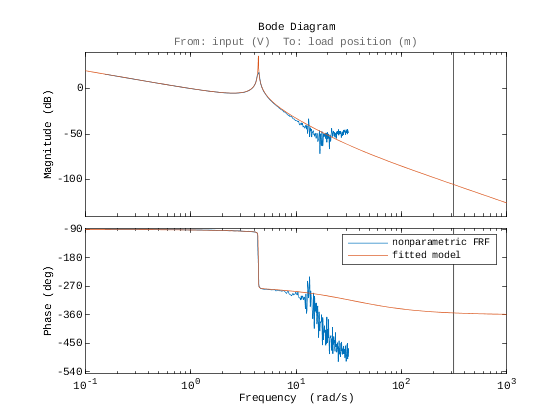

In [6]:
s = struct('numh', 1, 'numl', 0, 'denh', 3, 'denl', 1);                    % define the model structure 
Gp = param_ident('data', Gnp, 'method', 'nllsfdi', 'settings', s);         % fit a model with the structure we defined
opts = bodeoptions();                                                      % enhances the phase plot of the Bode diagram
opts.PhaseMatching = 'on';                                                 % enhances the phase plot of the Bode diagram
bodeplot(Gnp,Gp,opts);                                                     % make a Bode diagram 
legend('nonparametric FRF', 'fitted model');                               % add a legend

The method `nllsfdi` is the abbreviation of **n**on**l**inear **l**east-**s**quares **f**requency-**d**omain **i**dentification. It also to define frequency-dependent weighting functions (to emphasize the importance of certain frequencies, for example). For simplicitly, we did not consider those here and append the same weight to all frequencies. Now, we investigate how the model structure affects the accuracy of the model. The order of the model is preferably as low as possible, as this simplifies the control design. You can try out yourself different model orders or structured yourself below and compare with the result from above by playing with the numbers in the box below:


 Calculation of the LLS solution. 

 Re-calculation of the LLS solution. 

 Start of NLLS iterations 
teller = 1  ITER = 1  cost = 0.0375145  rel. change of cost = -0.000868616 
teller = 2  ITER = 2  cost = 0.0374748  rel. change of cost = -0.00105813 
teller = 3  ITER = 3  cost = 0.037396  rel. change of cost = -0.00210208 
teller = 4  ITER = 4  cost = 0.0372408  rel. change of cost = -0.00414963 
teller = 5  ITER = 5  cost = 0.0369394  rel. change of cost = -0.00809293 
teller = 6  ITER = 6  cost = 0.036369  rel. change of cost = -0.0154423 
teller = 7  ITER = 7  cost = 0.0353356  rel. change of cost = -0.0284156 
teller = 8  ITER = 8  cost = 0.0335845  rel. change of cost = -0.0495551 
teller = 9  ITER = 9  cost = 0.0308839  rel. change of cost = -0.0804116 
teller = 10  ITER = 10  cost = 0.0272438  rel. change of cost = -0.117865 
teller = 11  ITER = 11  cost = 0.0232909  rel. change of cost = -0.145091 
teller = 12  ITER = 12  cost = 0.0202998  rel. change of cost = -0.128427 
te

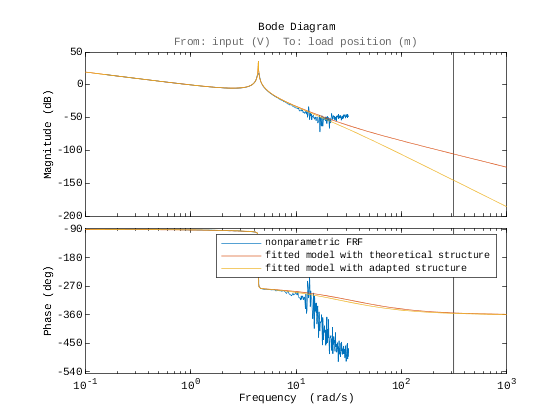

In [8]:
s_otherstructure = struct('numh', 1, 'numl', 0, 'denh', 5, 'denl', 1);                                          % let's for example change the highest denominator model to 4
Gp_otherstructure = param_ident('data', Gnp, 'method', 'nllsfdi', 'settings', s_otherstructure);                % fit a model with the structure we defined
bodeplot(Gnp,Gp,Gp_otherstructure,opts);                                                                        % make a Bode diagram 
legend('nonparametric FRF', 'fitted model with theoretical structure', 'fitted model with adapted structure');  % add a legend

Does the model still fit the nonparametric data properly? Of course -if relevant- we can also define more quantitative measures than an assessment based on a plot. We consider such measures to be out of the scope of this demonstrative tutorial.

### **2. Control design**

#### **Influence of the modulus margin on the damping of swinging motion**

We have prepared a working feedback controller design for you that ensures a zero steady-state tracking error on a step reference of the absolute load position. As one can intuitively expect, there is a trade-off between the response speed and the swinging motion of the load, which you will be able to play with yourself. We first explain our design, after which you can play with the parameters.

Let's start with defining the following control configuration. 

<br/> <center><img src="helpers/configuration.svg" style="width: 40%;"></center> <br/>

In fact, the part that is drawn in grey is not used in the controller design. However, we have added it as the simulation of the angle reveals more insight in the sequel. You can ignore it for the time being. Can you see how the code below corresponds to the figure?

In [9]:
% define our two main systems
G = IOSystem(1,2); G.add([Gp; Gp_angle]);
K = IOSystem(1,1);

% define some helper signals (aliases)
y = G.out(1); 
a = G.out(2);
u = G.in();
r = Signal(1);
e = r - y;

% define the connections
connections = [K.in == e ; K.out == u];

% define the closed-loop configuration
CL = IOSystem(G,K,connections);

Next, we specify the transfer functions that we think are useful.

In [10]:
% define the performance transfers
S = Channel(e/r, 'Sensitivity');
T = Channel(y/r, 'Complementary sensitivity (reference to load position)');
U = Channel(u/r, 'Control sensitivity'); 
A = Channel(a/r, 'Complementary sensitivity (reference to angle)');

We define the specifications as follows. In short, `WS*S` is minimized, corresponding to optimizing the bandwidth of the controller and (accordingly) its response speed. `MS` is the inverse modulus margin, that is, the smaller it is, the more damping we'll introduce in the system. For now, we constrain it to be less than 8 dB (`MS*S <= 1`). The second constraint enforces high-frequency roll-off on `U` (and, hence, on the controller): `WU*U <= 1`. This is important to avoid high-frequency noise in the loop: from the measured data (see above), we saw there is quite some noise in the system above 2-3 Hz. The exact numeric values are not that important for this example.

In [11]:
% define the specifications
sensitivity_peak_db = 8;                 % we want |S| < 8 dB for all frequencies
MS = Weight.DC(sensitivity_peak_db);
WS = Weight.LF(0.1, 2, -40);             % pushes S down at low frequencies with 2nd order roll-off -> optimizes the bandwidth
WU = Weight.HF(3, 2, -40);               % pushes U down at high frequencies with 2nd order roll-off -> makes the controller roll off to suppress noise

objective = WS*S;                        % define the objective
constraint = [MS*S <= 1;                 % define the constraints
              WU*U <= 1];

Now we can solve the problem and check out what it brings us.

H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Control sensitivity : [19] ->  [2]
H-infinity norm on channel Sensitivity : [23] ->  [31]
H-infinity norm on channel Sensitivity : [23] ->  [32]
H-infinity norm on channel Control sensitivity : [23] ->  [33]
ssminreal: The output system is proper.
ssminreal: 2 state(s) removed.
solving with mixedHinfsyn
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Control sensitivity : [19] ->  [2]
H-infinity norm on channel Sensitivity : [74] ->  [82]
H-infinity norm on channel Sensitivity : [74] ->  [83]
H-infinity norm on channel Control sensitivity : [74] ->  [84]
ssminreal: The output system is proper.
ssminreal: 2 state(s) removed.

 Solver for linear objective minimization under LMI constraints 

 Iterations   :    Best objective value so far 
 
     1
     2
     3
    

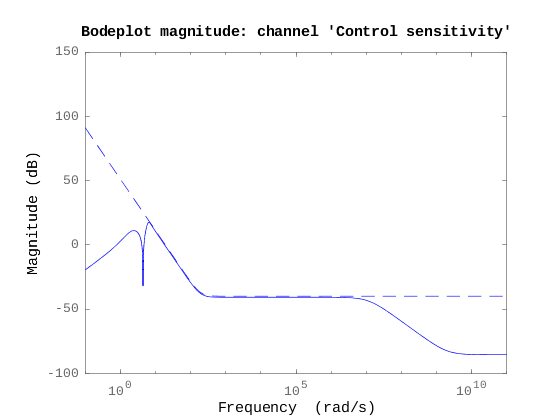

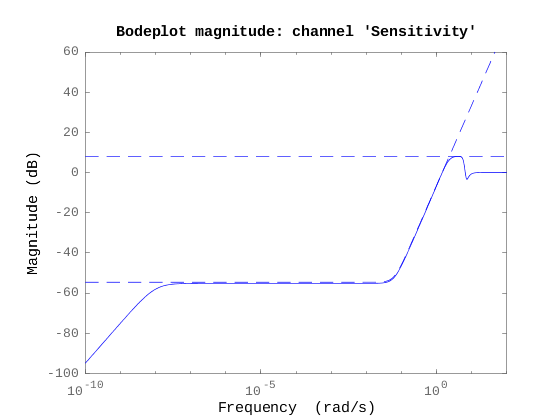

In [12]:
[~,~,info] = CL.solve(objective, constraint, K);        % solve the problem
showall(info);                                          % show the resulting loop shapes

We see the loop shapes are tightly following our specifications, which is good! Let us have a look to what happens if we want to move the load 40 cm with a step reference:

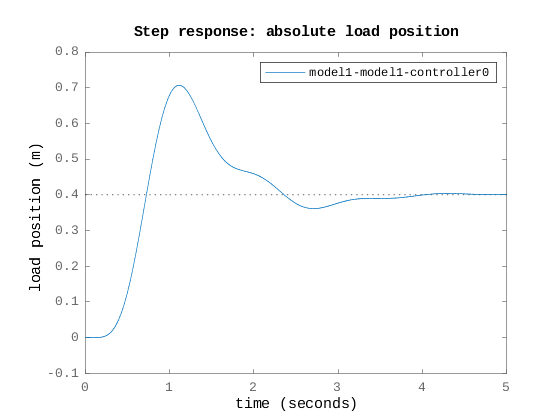

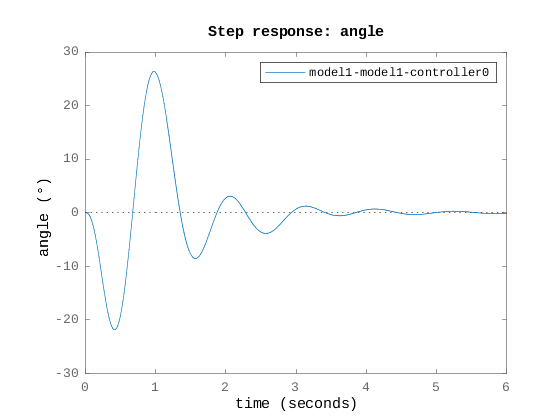

In [13]:
opts = stepDataOptions('StepAmplitude', 0.4);
figure; step(CL(T),opts); title('Step response: absolute load position'); xlabel('time'); ylabel('load position (m)');     % step response of the absolute load position
figure; step(CL(A),opts); title('Step response: angle'); xlabel('time'); ylabel('angle (°)');                              % response of the angle to a step reference on the absolute load position

We notice that tracking is indeed fast; the rise time is about 1 second or less. However, the oscillations of the angle are still rather large, as we see in the second plot. Suppose that our application requires more damping. Try different values for the modulus margin, smaller than 6 dB, and check how the step responses change. You can start from this code, which constrains it to 4 dB instead of 6 dB. What happens if you decrease the value? How does the response speed change when the oscillations become smaller? Do you see the trade-off?

H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Control sensitivity : [19] ->  [2]
H-infinity norm on channel Sensitivity : [174] ->  [182]
H-infinity norm on channel Sensitivity : [174] ->  [183]
H-infinity norm on channel Control sensitivity : [174] ->  [184]
ssminreal: The output system is proper.
ssminreal: 2 state(s) removed.
solving with mixedHinfsyn
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Sensitivity : [19] ->  [21]
H-infinity norm on channel Control sensitivity : [19] ->  [2]
H-infinity norm on channel Sensitivity : [225] ->  [233]
H-infinity norm on channel Sensitivity : [225] ->  [234]
H-infinity norm on channel Control sensitivity : [225] ->  [235]
ssminreal: The output system is proper.
ssminreal: 2 state(s) removed.

 Solver for linear objective minimization under LMI constraints 

 Iterations   :    Best objective value so far 
 
     1
     2

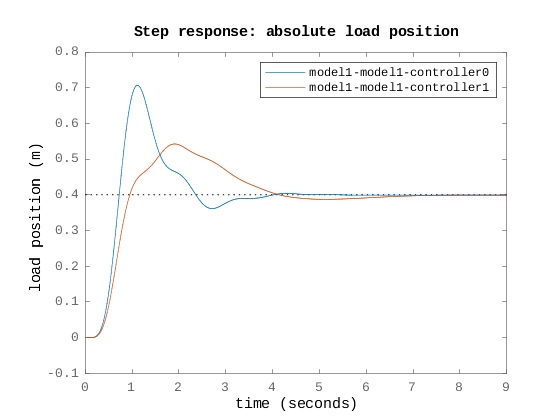

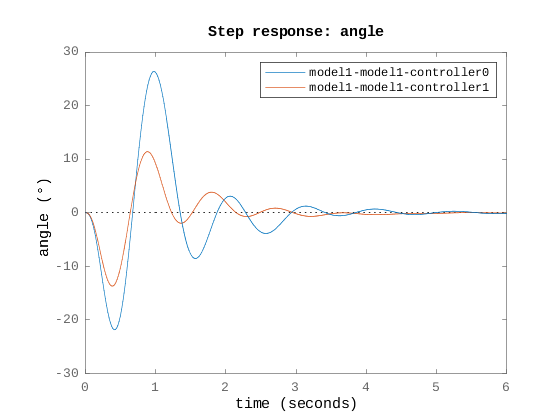

In [14]:
sensitivity_peak_db = 4;                 % lower this value to enforce more damping or the swinging motion
MS = Weight.DC(sensitivity_peak_db);     

objective = WS*S;                        % the design remains the same, but with other values for MS
constraint = [MS*S <= 1;
              WU*U <= 1];
[~,~,info] = CL.solve(objective, constraint, K); 

figure; step(CL(T),opts); title('Step response: absolute load position'); xlabel('time'); ylabel('load position (m)'); 
figure; step(CL(A),opts); title('Step response: angle'); xlabel('time'); ylabel('angle (°)'); 